# text2poem

### Aim
Given a textual description, generate a poem from it. 

### To-Do
- [ ] Clean up the variable names, etc
- [ ] Understand the T5 architecture and freeze the base layers if needed
- [ ] Create the $(\text{summary}, \ \text{poem})$ dataset using sites like [Poem Analysis](https://poemanalysis.com/). Ideally, smaller poems would be preffered. Might need to create manually, as scraping is not only difficult, but also lead to bad data. Stanza-by-Stanza is too detailed, and some summaries barely contain any information about the poem. Thus, data samples may need to be manually checked. Need to select famous poems that have good quality summaries available.
    - Doesn't work properly when tested with training set of $9$ poems, will need to try with more data
    - Another alternative, $(\text{topic}, \ \text{poem})$ dataset. Given a set of keywords, generate a poem. Dataset creation would be simple using LDA topic modelling etc.
        - [Topic Idenitification NLP 1](https://www.pluralsight.com/guides/topic-identification-nlp)
        - [Topic Idenitification NLP 2](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)
        - [Example](https://monkeylearn.com/keyword-extractor-online/)
- [ ] Clean the dataset, remove very long poems, if possible select by prominent authors, remove poems with no rhyming scheme.
- [ ] Change the RAKE algorithm
    - Maybe try using POS tagging in some way
- [ ] Check whether tokenizer preserves "\n" else replace by some other token
    - It's based on SentencePiece which doesn't preserve "\n"
- [ ] Calculate lengths of poems after data cleaning
### Ideas
- [ ] Rhyming scheme as T5 prefix

### References
- [Base code for this notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) (This had quite a few bugs) 
- [T5 finetuning tips](https://discuss.huggingface.co/t/t5-finetuning-tips/684/2)
- [T5 Docs](https://huggingface.co/transformers/model_doc/t5.html)
- [Training T5](https://huggingface.co/transformers/model_doc/t5.html#training) (Not detailed enough)
- [Finetuning T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) (Probably the most extensive tutorial)
- [Few Shot Learning with T5](https://towardsdatascience.com/poor-mans-gpt-3-few-shot-text-generation-with-t5-transformer-51f1b01f843e)
- [Some Famous Poetry](https://medium.com/@EmEmbarty/31-of-the-best-and-most-famous-short-classic-poems-of-all-time-e445986e6df)
- [Poetry Summaries](https://www.litcharts.com/poetry/)
- [A great blog on how to generate text](https://huggingface.co/blog/how-to-generate)


## Install Dependencies

In [49]:
# Transformer changes very frequently, thus the version is important
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

## Connect to GDrive

In [50]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Start
To reset the notebook, run from this point

In [51]:
%reset -f

## Import Libraries

In [52]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# The T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [53]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [54]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics_200_top_authors.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

In [55]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [56]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [57]:
def replaceSep(text, sep = " | "):
    if type(text) == float:
        print(text)
    return text.replace("\n", sep)

In [58]:
def loadDF(path, n_rows = None, split = 0.9,  prefix = "summarize: "):
    """ Loads the CSV data and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")
    df.dropna(inplace = True)
    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]
    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)
    # Add a suitable prefix to the text input
    df.input = prefix + df.input
    # Truncate the dataset if required
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    df["input"] = df["input"].apply(replaceSep)
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, train_size = split, random_state = SEED, shuffle = True)
    
    if len(df_val) > 5:
        df_val = df_val[:5]

    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [59]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [60]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

In [61]:
# ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
# ds_train[0] # For quickly testing the data format

In [62]:
# temp = tokenizer(
#     ["hello\nmy friend* how| are|you today*haha"],
#     # max_length = self.inp_len, 
#     #padding = "max_length", 
#     #truncation = True,
#     return_tensors = "pt"
# ).input_ids
# ok = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in temp]
# print(ok)

## Train and Validate Functions:

In [63]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [64]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [65]:
def generate(topics):

    input = "poetify: " + " | ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [66]:
def genSample(topics, min_length, max_length, rep_penalty):

    input = "poetify: " + " | ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        # temperature=0.7,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [67]:
# gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"])

## Main

In [68]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [69]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = "poemify: ")
print(len(df), len(df_train), len(df_val))

487 438 5


In [70]:
display(df)

,output,input
0,"I have no wit, no words, no tears; | My heart ...",poemify: faded leaf | shall—the sap | mine eye...
1,"A Bird, came down the Walk - | He did not know...",poemify: softer Home | frightened Beads | rapi...
2,My heart is like a singing bird | Whose nest i...,poemify: hundred eyes | silver fleurs-de-lys |...
3,"You did not come, | And marching Time drew on,...",poemify: human deeds | dear presence | high co...
4,"Out of a fired ship, which by no way | But dro...",poemify: burnt ship | fired ship | drown | fla...
...,...,...
484,"Sweet and low, sweet and low, | Wind of the we...",poemify: western sea | dying | breathe | sleep...
485,"Tears, idle tears, I know not what they mean, ...",poemify: first beam | half-awaken 'd | fancy f...
486,The splendour falls on castle walls | And snow...,poemify: wild cataract | long light | rich sky...
487,"Thy voice is heard thro' rolling drums, | That...",poemify: thy knee | thro | drums | battle | ro...


In [71]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

219 3


### Loading the Model

In [72]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [73]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [74]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [75]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9


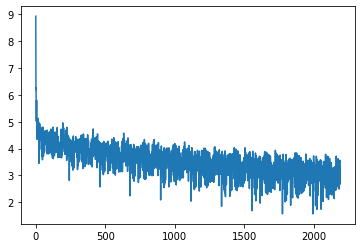

In [76]:
plt.plot(range(len(losses)), losses)
plt.show()

In [77]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [78]:
display(results)

,Generated Text,Actual Text
0,"I hear the tide moving away | From my heart, a...","Sunset and evening star, | And one clear call ..."
1,"The cold world is falling, | And the realms ar...","And did young Stephen sicken, | And did young ..."
2,"I have no instinct to aspire, | And my spirit ...",Ethereal minstrel! pilgrim of the sky! | Dost ...
3,"I | Have a pleasant lot of charmed sleep, and ...",Where sunless rivers weep | Their waves into t...
4,"Then, the throstle sing'd in his barrend leave...","Up! up! my Friend, and quit your books; | Or s..."


In [79]:
x = 4
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

Then, the throstle sing'd in his barrend leaves. | And then I heard him sing; and now they are gone: | They say that it is moral evil! | But when we hear them singing their songs of love? | So sweet evening you can see us laughing with our beauteous forms—and so on to me will not stop there or wait for more than one word from my heart-wrestling mind–the mean preacher’ll die again... 

Up! up! my Friend, and quit your books; | Or surely you'll grow double: | Up! up! my Friend, and clear your looks; | Why all this toil and trouble? | | The sun above the mountain's head, | A freshening lustre mellow | Through all the long green fields has spread, | His first sweet evening yellow. | | Books! 'tis a dull and endless strife: | Come, hear the woodland linnet, | How sweet his music! on my life, | There's more of wisdom in it. | | And hark! how blithe the throstle sings! | He, too, is no mean preacher: | Come forth into the light of things, | Let Nature be your teacher. | | She has a world of r

In [80]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4)

This river has tripped the tree,
The winds have driven our leaves away; but this is where weeping was:
They will desolate us all:
There I shall not look back on you.

I shall be here since tonight and my sun comes out to sleep as well?
If this wind are there do I would say that for it should die.
My name must be at hand—a woodward forest]
Will weep from the very beginning once more!


In [81]:
gen = genSample(["happy", "elated smile", "good luck", "persian rugs", "beautiful eyes"], 100, 500, 1.3)

Then, by virtue of a beautiful smile, that I recollect
That having one who love you and your family knows
What is good luck? to you with this:
Good luck for yourself in an elated smile. To me, now all but happy are made from persian rugs.
So glad about the wonderful eyes of your country.
And thank you for what has shown!
My dearest to you as if you were not true!
But be fine as if you am so smiling or happy;
For any wish God's sake, it is time to pray at once,
All my very best hope everlastingly thinks
That you give him some kind—I will have no way to speak when we travel,
With free-flowing in her words.


In [90]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.5)

The singing trees and dances green
In the glowing sun of dawn,
And each smiling soul with one smile that amirates.
Ah! what should have I do?
We rejoice in our joyous work:
And how can I create this contented spirit;
They delight on us just by laughing at ourselves as they pass along....
With laughter like an elated smile we are all set upon—your heart is easy
To see these happy faces coming up from sky to sky.


In [83]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.1)

I am joyous and fervourous,
With glad faces from the glowing sun to the tree.
This is the joyous spirit that shines.


The dance trees have not resound'd as they shine in the sky.

You are so joyful that you might never return for the day.
It is one of those flowers and flowers that shine through me all day.

No child will laugh like an angel with joyous smile.

No child will know her happy faces without fear of danger.

When we give a joyous smile to love,
And cheering, singing at the flame!

From my glowing sun off and down and turn up in their smile on the dancing trees,
The smile they bear over it as much as ever;
As soon as the joyous smile,
For the joyous glow that shines.


In [94]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.1)

One, one, who is tired and sick of your ear;
And having the same light that takes long for me to forget,
Or take the other, taking the back, to see what I feel
In my thoughts they have read,
Do not give you them, even more.

I am tired in light that takes long time;
I run the hoary sky too soon!
I look the same and see, like a simple stone, where I lie
In a pond I feel about,
What I find ourselves living in the hoary sky,
That’s tired and tired,
Was tired of my job:
If I could save her from death by some consistent light,
The other, upon my back or ankle,
And then love me as if I could get away.


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```